In [1]:
# Packages

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters

path = 'example_set_2.txt'
N = 0.001
threshold = 1

# Data Processing

In [3]:
# Data processing

graph = []
nodes = []

file = open(path)
for line in file:
    source, target = line.split('\t')
    nodes.append(int(source))
    nodes.append(int(target))
    graph.append((int(source), int(target)))
    
nodes = list(set(nodes))
n = int(len(nodes) * N)

In [4]:
# Print graph status

print('Node number: {}'.format(len(nodes)))
print('Edge number: {}'.format(len(graph)))

Node number: 75879
Edge number: 508837


# Seeds Selection

## Degree

In [28]:
# Seeds selection: Degree 

degree = {}

for edge in graph: 
    if edge[0] in degree:
        degree[edge[0]] += 1
    else:
        degree[edge[0]] = 1
    if edge[1] in degree:
        degree[edge[1]] += 1
    else:
        degree[edge[1]] = 1

seeds = list({k: v for k, v in sorted(degree.items(), key=lambda item: item[1], reverse=True)}.keys())[:n]

## Random

In [122]:
# Seeds selection: Random

seeds = []

np.random.shuffle(nodes)

seeds =  nodes[:n]

## Degree Discount

In [ ]:
# Seeds selection: Degree Discount

out_degree = {}
connection = {}
seeds = []

for edge in graph:
    if edge[1] in connection:
        connection[edge[1]].append(edge[0])
    else:
        connection[edge[1]] = [edge[0]]

    if edge[0] in out_degree:
        out_degree[edge[0]] += 1
    else:
        out_degree[edge[0]] = 1

while len(seeds) < n:
    # out_degree = {k: v for k, v in sorted(degree.items(), key=lambda item: item[0])}
    seed = sorted(out_degree.items(), key=lambda item: item[1], reverse=True)[0][0]
    seeds.append(seed)
    out_degree[seed] = -1
    for node in connection[seed]:
        out_degree[node] -= 1

## Degree Neighbor

In [ ]:
# Seeds selection: Degree Neighbor

out_degree = {}
centrality_score = {}
seeds = []

for edge in graph:
    if edge[0] in out_degree:
        out_degree[edge[0]] += 1
    else:
        out_degree[edge[0]] = 1

centrality_score = out_degree.copy()

for edge in graph:
    if edge[1] in out_degree:
        centrality_score[edge[0]] += out_degree[edge[1]]
    else:
        pass

i = 0
centrality_score = {k: v for k, v in sorted(centrality_score.items(), key=lambda item: item[0])}
for node, score in sorted(centrality_score.items(), key=lambda item: item[1], reverse=True):
    if i >= n:
        break
    else:
        i += 1
    seeds.append(node)

## Degree Neighbor Fix

In [ ]:
# Seeds selection: Degree Neighbor Fix

out_degree = {}
centrality_score = {}
connection = {}
seeds = []

for edge in graph:
    if edge[1] in connection:
        connection[edge[1]].append(edge[0])
    else:
        connection[edge[1]] = [edge[0]]

    if edge[0] in out_degree:
        out_degree[edge[0]] += 1
    else:
        out_degree[edge[0]] = 1

centrality_score = out_degree.copy()

for edge in graph:
    if edge[1] in out_degree:
        centrality_score[edge[0]] += out_degree[edge[1]]
    else:
        pass

while len(seeds) < n:
    seed = sorted(centrality_score.items(), key=lambda item: item[1], reverse=True)[0][0]
    seeds.append(seed)
    centrality_score[seed] = -1
    for node in connection[seed]:
        centrality_score[node] -= out_degree[seed]

## MIA

In [ ]:
# Seeds selection: MIA

theta = 0.1
nodes = []
out_connection = {}
centrality_score = {}
seeds = []

def calculate_centrality(node, out_connection, centrality_score, ap, theta):
    if node not in out_connection.keys():
        return 1
    
    ap *= 1 / len(out_connection[node])
    if ap < theta:
        return 1
    
    for sub_node in out_connection[node]:
        centrality_score += calculate_centrality(sub_node, out_connection, centrality_score, ap, theta)
    return centrality_score

for edge in graph:
    nodes.append(edge[0])
    nodes.append(edge[1])

    if edge[0] in out_connection:
        out_connection[edge[0]].append(edge[1])
    else:
        out_connection[edge[0]] = [edge[1]]

nodes = list(set(nodes))

for node in nodes:
    centrality_score[node] = calculate_centrality(node, out_connection, 0, ap=1, theta=theta)

i = 0
centrality_score = {k: v for k, v in sorted(centrality_score.items(), key=lambda item: item[0])}
for node, score in sorted(centrality_score.items(), key=lambda item: item[1], reverse=True):
    if i >= n:
        break
    else:
        i += 1
    seeds.append(node)

# Calculate Influent Number (One Round)

## Preparation

In [30]:
in_degree = {}
inactive_nodes = []
active_nodes = []
actived_nodes = []
nodes_status = {}

for edge in graph: 
    if edge[0] in seeds:
        active_nodes.append(edge[0])
    else:
        inactive_nodes.append(edge[0])
    
    if edge[1] in seeds:
        active_nodes.append(edge[1])
    else:
        inactive_nodes.append(edge[1])
    
    if edge[1] in in_degree:
        in_degree[edge[1]] += 1
    else:
        in_degree[edge[1]] = 1

active_nodes = list(set(active_nodes))
inactive_nodes = list(set(inactive_nodes))

for node in nodes:
    nodes_status[node] = 0
for node in active_nodes:
    nodes_status[node] = 1

## Calculation

In [32]:
epoch = 0
num_new_actived_nodes = []
num_actived_nodes = 0
num_actived_nodes_list = []
while(active_nodes):
    epoch += 1
    num_new_actived_nodes.append(len(active_nodes))
    num_actived_nodes += len(active_nodes)
    num_actived_nodes_list.append(num_actived_nodes)
    
    new_actived_nodes = []
    for edge in graph:
        if nodes_status[edge[0]] == 1:
            if nodes_status[edge[1]] == 0:
                p = np.array([1 - threshold / in_degree[edge[1]], threshold / in_degree[edge[1]]])
                flag = np.random.choice([0, 1], p=p.ravel())

                if flag:
                    new_actived_nodes.append(edge[1])
    
    for node in active_nodes:
        nodes_status[node] = 2
    for node in new_actived_nodes:
        nodes_status[node] = 1
    active_nodes = new_actived_nodes

final_actived_node = 0
for node in nodes:
    if nodes_status[node] == 2:
        final_actived_node += 1

## Result & Statistics

Finally acticed nodes: 9154


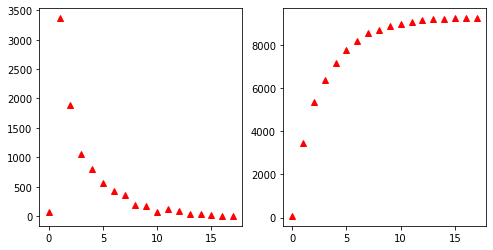

In [35]:
print('Finally acticed nodes: {}'.format(final_actived_node)) 

epoches = np.arange(epoch)

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.plot(epoches, num_new_actived_nodes, 'r^')
plt.subplot(122)
plt.plot(epoches, num_actived_nodes_list, 'r^')

plt.show()

# Calculate Influent Number (Multi Round)

In [42]:
epoches = 10
final_actived_node_stastics = []

## Preperation

In [43]:
in_degree = {}
init_inactive_nodes = []
init_active_nodes = []
init_actived_nodes = []
init_nodes_status = {}

for edge in graph: 
    if edge[0] in seeds:
        init_active_nodes.append(edge[0])
    else:
        init_inactive_nodes.append(edge[0])

    if edge[1] in seeds:
        init_active_nodes.append(edge[1])
    else:
        init_inactive_nodes.append(edge[1])

    if edge[1] in in_degree:
        in_degree[edge[1]] += 1
    else:
        in_degree[edge[1]] = 1

init_active_nodes = list(set(init_active_nodes))
init_inactive_nodes = list(set(init_inactive_nodes))

for node in nodes:
    init_nodes_status[node] = 0
for node in active_nodes:
    init_nodes_status[node] = 1

In [44]:
for epoch in range(epoches):
    inactive_nodes = init_inactive_nodes
    active_nodes = init_active_nodes
    actived_nodes = init_actived_nodes
    nodes_status = init_nodes_status.copy()

    while(active_nodes):
        new_actived_nodes = []
        for edge in graph:
            if nodes_status[edge[0]] == 1:
                if nodes_status[edge[1]] == 0:
                    p = np.array([1 - threshold / in_degree[edge[1]], threshold / in_degree[edge[1]]])
                    flag = np.random.choice([0, 1], p=p.ravel())

                    if flag:
                        new_actived_nodes.append(edge[1])

        for node in active_nodes:
            nodes_status[node] = 2
        for node in new_actived_nodes:
            nodes_status[node] = 1
        active_nodes = new_actived_nodes

    final_actived_node = 0
    for node in nodes:
        if nodes_status[node] == 2:
            final_actived_node += 1
    
    final_actived_node_stastics.append(final_actived_node)

## Results & Statistics

Average finally acticed nodes: 75.0


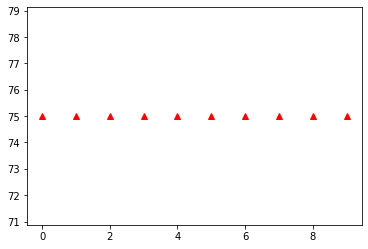

In [45]:
print('Average finally acticed nodes: {}'.format(np.mean(np.array(final_actived_node_stastics)))) 

plt.plot(range(epoches), final_actived_node_stastics, 'r^')
plt.show()